 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

# Outlook

In this notebook, you will code a naive actor-critic algorithm in the tabular case. Then you will tune it using grid search and Bayesian optimization, potentially using the [optuna](https://optuna.readthedocs.io/en/stable/) library.
Finally, you will get the best hyper-parameters obtained with both methods and perform a statistical test to see if there is a statistically significant difference between these methods and with respect to naive hyper-parameter values.

## Install libraries

### 展望

在本笔记本中，你将编写一个用于表格情况的简单的**演员-评论家算法**（Actor-Critic Algorithm）。然后，你将使用**网格搜索**和**贝叶斯优化**来对其进行调优，可能会使用 [optuna](https://optuna.readthedocs.io/en/stable/) 库。  
最后，你将获取通过这两种方法得到的最佳超参数，并进行统计测试，以确定这些方法与原始超参数值之间是否存在统计学上显著的差异。

## 安装库

In [24]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.2")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")
easyinstall("optuna")
easyinstall("gymnasium")
easyinstall("mazemdp")

import numpy as np
import os
from typing import List

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

In [25]:
import torch
import torch.nn as nn

In [26]:
import gymnasium as gym

from bbrl.utils.chrono import Chrono

import matplotlib
# matplotlib.use('TkAgg')                                 # 要把 matplotlib.use('TkAgg') 严格放在 import.matplotlib 后面
import matplotlib.pyplot as plt

from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial

# matplotlib.use("TkAgg")

# Step 1: Coding the naive Actor-critic algorithm

We consider the naive actor-critic algorithm with a categorical policy.
The algorithm learns a critic with the standard temporal difference mechanism
using a learning rate $\alpha_{critic}$.

We consider a value-based critic $V(s)$. The extension to an action value function $Q(s,a)$ is straightforward.

To update the critic, the algorithm computes the temporal difference error:

$$\delta_t = r(s_t, a_t) + \gamma V^{(n)}(s_{t+1})-V^{(n)}(s_t).$$

Then it applies it to the critic:

$$V^{(n+1)}(s_t) = V^{(n)}(s_t) + \alpha_{critic} \delta_t.$$

To update the actor, the general idea is the same, using the temporal difference error with another learning rate $\alpha_{actor}$.

However, naively applying the same learning rule would not ensure that the probabilities of all actions in a state sum to 1.
Besides, when the temporal difference error $\delta_t$ is negative, it may happen that the probability of an action gets negative or null, which raises an issue when applying renormalization.

So, instead of applying the naive rule, we apply the following one:
$$ 
\pi_{temp}(a_t|s_t) =  \begin{cases}
\pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t & \mathrm{if } \pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t > 10^{-8}\\
10^{-8} & \mathrm{otherwise.} \\
\end{cases}
$$

Then we can apply renormalization so that the probabilities of actions still sum to 1, with
$$
\forall a, \pi^{(i+1)}(a|s_t) = \frac{\pi_{temp}^{(i+1)}(a|s_t)} {\sum_{a'} \pi_{temp}^{(i+1)}(a'|s_t)}
$$ with
$$ 
\pi_{temp}^{(i+1)}(a|s_t) =  \begin{cases}
\pi_{temp}(a|s_t) & \mathrm{if } a = a_t\\
\pi^{(i)}(a|s_t) & \mathrm{otherwise.} \\
\end{cases}
$$

## Exercise 1

### 1. Code the naive actor-critic algorithm as specified above.

Some hints:

- a good idea to build this code it to take inspiration from the code of Q-learning, to add an actor (a categorical policy), both learning rates,
and to take care about the renormalization function.

- for the next steps of this lab, having a function to repeatedly call your actor-critic algorithm and save the learning trajectories and
norms of the value function is a good idea.

### 第一步：编写简单的演员-评论家算法

我们将考虑带有**分类策略**的简单演员-评论家（Actor-Critic）算法。  
该算法通过标准的**时序差分机制**（temporal difference mechanism）学习一个评论家（critic），使用学习率 $\alpha_{critic}$。

我们考虑一个基于值的评论家 $V(s)$。将其扩展到**动作值函数** $Q(s,a)$ 是直接的。

为了更新评论家，算法计算**时序差分误差**：

$$\delta_t = r(s_t, a_t) + \gamma V^{(n)}(s_{t+1}) - V^{(n)}(s_t).$$

然后将其应用于评论家的更新：

$$V^{(n+1)}(s_t) = V^{(n)}(s_t) + \alpha_{critic} \delta_t.$$

对于**演员**（actor）的更新，基本思路相同，使用时序差分误差并结合另一个学习率 $ \alpha_{actor} $。

然而，直接应用相同的学习规则不能保证在某个状态下所有动作的概率之和为1。  
此外，当时序差分误差 $\delta_t$ 为负时，可能导致某个动作的概率变为负数或为零，这在归一化时会产生问题。

因此，**不是直接应用简单规则**，我们使用以下更新规则：

$$ 
\pi_{temp}(a_t|s_t) =  \begin{cases}
\pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t & \mathrm{if } \pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t > 10^{-8}\\
10^{-8} & \mathrm{otherwise.} \\
\end{cases}
$$

然后我们可以应用归一化，使得动作的概率和仍然等于1：

$$
\forall a, \pi^{(i+1)}(a|s_t) = \frac{\pi_{temp}^{(i+1)}(a|s_t)} {\sum_{a'} \pi_{temp}^{(i+1)}(a'|s_t)}
$$

其中，

$$ 
\pi_{temp}^{(i+1)}(a|s_t) =  \begin{cases}
\pi_{temp}(a|s_t) & \mathrm{if } a = a_t\\
\pi^{(i)}(a|s_t) & \mathrm{otherwise.} \\
\end{cases}
$$

## 练习 1

### 1. 按照上面的描述编写简单的演员-评论家算法。

一些提示：

- 编写此代码的一个好方法是参考**Q-learning**的代码，添加一个**演员**（分类策略）、两个学习率，并注意**归一化函数**的处理。

- 对于本实验的后续步骤，建议你编写一个函数，重复调用你的演员-评论家算法，并保存学习轨迹和值函数的范数。

In [27]:
# To be completed...

def Actor_Critic(
        mdp: MazeMDPEnv,
        nb_episodes: int = 20,
        timeout: int = 50,
        alpha_critic: float = 0.5,
        alpha_actor: float = 0.5,
        render: bool = True,
        init_v: float = 0.0,
        uniform: bool = True,
):
    # alpha_critic is the learning rate of Critic
    # alpha_actor is the learning rate of Actor

    # Initialize the state value function
    v = np.zeros(mdp.unwrapped.nb_states)
    v_min = np.zeros(mdp.unwrapped.nb_states)
    v[:] = init_v
    v_list = []
    time_list = []

    # Initialize the actor policy
    actor_policy = np.ones((mdp.unwrapped.nb_states, mdp.action_space.n)) / mdp.action_space.n

    # Run learning cycle
    mdp.timeout = timeout    # episoda length

    if render:
        mdp.init_draw("Actor-Critic")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=uniform)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show the agent in the maze
            if render:
                mdp.draw_v_pi(v,actor_policy.argmax(axis=1))

            # Draw an action
            u = np.random.choice(mdp.action_space.n, p=actor_policy[x])

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)

            # Calculate the delta
            delta = r + mdp.unwrapped.gamma * v[y] - v[x]

            # Update the value fonction of Critic
            v[x] += alpha_critic * delta

            # Update the Actor policy
            if actor_policy[x,u] + alpha_actor * delta > 1e-8:
                actor_policy[x,u] += alpha_actor * delta
            else:
                actor_policy[x,u] = 1e-8

            actor_policy[x] /= np.sum(actor_policy[x])

            # Update the agent position
            x = y
            cpt += 1

        v_list.append(np.linalg.norm(np.maximum(v,v_min)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(v, actor_policy)

    return v, v_list, time_list



# assert False, 'Not implemented yet'


### 2. Provide a plot function

Your plot function should show the evolution through time of number of steps the agent takes to find the reward in the maze.
If your algorithm works, this number of steps should decrease through time.

Your plot function should also show a mean and a standard deviation (or some more advanced statistics) over a collection of learning runs.

### 2. 提供一个绘图函数

你的绘图函数应展示**随着时间推移，智能体找到迷宫中的奖励所花步数的变化**。  
如果你的算法有效，那么这些步数应该随着时间的推移逐渐减少。

你的绘图函数还应该展示**多个学习运行的均值**和**标准差**（或者一些更高级的统计数据）。

In [28]:
# To be completed...


# assert False, 'Not implemented yet'


## Actor-critic hyper-parameters

To represent the hyper-parameters of the experiments performed in this notebook, we suggest using the dictionary below.
This dictionary can be read using omegaconf.
Using it is not mandatory.
You can also change the value of hyper-parameters or environment parameters at will.

## 演员-评论家算法的超参数

为了表示本笔记本中实验的超参数，我们建议使用以下字典。  
该字典可以通过 `omegaconf` 读取。  
使用它并不是强制的，你也可以随意更改超参数或环境参数的值。

In [29]:
ac_params = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "rgb_array",
        },
        
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",

    "nb_episodes": 100,
    "timeout": 200,
    "render": False, # True, # 
    "nb_repeats": 5,

    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

### 3. Test your code

Once everything looks OK, save the obtained plot for your lab report

In [30]:
# To be completed...



# assert False, 'Not implemented yet'

In [31]:
# 跑迷宫测试

env = gym.make(
    id="MazeMDP-v0",
    kwargs={"width": 5, "height": 5, "ratio": 0.2},
    render_mode="rgb_array",
)

env.reset()
env.unwrapped.init_draw("The maze")


array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

In [32]:
v, v_list, time_list = Actor_Critic(
    env, 
    ac_params["nb_episodes"], 
    ac_params["timeout"], 
    ac_params["alpha_critic"], 
    ac_params["alpha_actor"],
    render=False,
    init_v=0,
    uniform=True
)

In [33]:
print(v)

[2.56525526 1.08402617 2.90036288 5.08346332 4.02645856 4.89142006
 6.07456231 4.08235018 5.6124745  6.94688488 7.93356271 2.56473038
 6.34942688 5.89335453 8.87278643 6.08784295 7.11705417 7.9456974
 8.85016555 9.88469494]


# Step 2: Tuning hyper-parameters

In this part, you have to optimize two hyper-parameters of the actor-critic algorithm, namely the actor and critic learning rates.
You have to do so using a simple grid search method and some Bayesian optimization method.
For the latter, we suggest using the default sampler from [optuna](https://optuna.readthedocs.io/en/stable/).
Follow the above link to understand how optuna works.
Note that it also supports grid search and many other hyper-parameters tuning algorithms.

You should make sure that the hyper-parameters tuning algorithms that you compare benefit from the same training budget
We suggest 400 training runs overall for each method,
which means 20 values each for the actor and the critic learning rates in the case of grid search.

## Exercise 2

### 1. Perform hyper-parameters tuning with two algorithms as suggested above.

### 2. Provide a "heatmap" of the norm of the value function given the hyper-parameters, after training for each pair of hyper-parameters.

### 3. Collect the value of the best hyper-parameters found with each algorithm. You will need them for Step 3.

### 4. Include in your report the heatmaps and the best hyper-parameters found for each method.

# 第二步：调优超参数

在本部分中，你需要优化演员-评论家算法中的两个超参数，分别是**演员**和**评论家**的学习率。  
你需要使用**简单网格搜索方法**和某种**贝叶斯优化方法**来完成此任务。  
对于后者，我们建议使用 [optuna](https://optuna.readthedocs.io/en/stable/) 的默认采样器。  
你可以点击上面的链接了解 optuna 的工作原理。  
请注意，optuna 也支持网格搜索和其他多种超参数调优算法。

你应该确保所比较的超参数调优算法拥有相同的训练预算。  
我们建议每种方法整体进行 400 次训练运行，  
这意味着在网格搜索的情况下，演员和评论家学习率各取 20 个值。

## 练习 2

### 1. 使用上述建议的两种算法进行超参数调优。

### 2. 提供一个关于值函数范数的“热图”（heatmap），展示每对超参数在训练后的表现。

### 3. 收集每种算法找到的最佳超参数值。你将在步骤3中需要这些参数。

### 4. 在报告中包含热图以及每种方法找到的最佳超参数。

In [34]:
# To be completed...


# assert False, 'Not implemented yet'

In [35]:
# Bayesian optimization method (optuna)

import optuna

def objective(trial):
    # 定义 alpha_actor 和 alpha_critic 的搜索范围
    alpha_actor = trial.suggest_float("alpha_actor", 0.01, 1.0, log=True)
    alpha_critic = trial.suggest_float("alpha_critic", 0.01, 1.0, log=True)

    # 初始化迷宫环境
    mdp = env

    # 调用 Actor-Critic 算法
    v, v_list, time_list = Actor_Critic(
        mdp = env,
        nb_episodes = ac_params["nb_episodes"], 
        timeout = ac_params["timeout"], 
        alpha_critic = alpha_critic, 
        alpha_actor = alpha_actor,
        render = False,
        init_v = 0
    )
    
    # 性能指标
    final_value_norm = v_list[-1]

    return final_value_norm

In [36]:
# 创建一个 Study 对象并指定优化方向为最大化
study = optuna.create_study(direction="maximize")

# 运行 400 次
study.optimize(objective, n_trials=400)

# 输出结果
print('best alpha_actor: ', study.best_params["alpha_actor"])
print('best alpha_critic: ', study.best_params["alpha_critic"])
print('best value: ', study.best_value)

[I 2024-10-05 16:52:55,356] A new study created in memory with name: no-name-ae29c801-2450-41bc-8efc-bb7034f9041f
[I 2024-10-05 16:52:55,525] Trial 0 finished with value: 29.487915898211973 and parameters: {'alpha_actor': 0.3001833991336012, 'alpha_critic': 0.9604815733692736}. Best is trial 0 with value: 29.487915898211973.
[I 2024-10-05 16:52:55,858] Trial 1 finished with value: 0.9401424827891681 and parameters: {'alpha_actor': 0.048966600354368124, 'alpha_critic': 0.02428345279111166}. Best is trial 0 with value: 29.487915898211973.
[I 2024-10-05 16:52:56,219] Trial 2 finished with value: 0.6315121635621654 and parameters: {'alpha_actor': 0.03422873227779268, 'alpha_critic': 0.018220908592735178}. Best is trial 0 with value: 29.487915898211973.
[I 2024-10-05 16:52:56,482] Trial 3 finished with value: 9.826063390373816 and parameters: {'alpha_actor': 0.017315796142122523, 'alpha_critic': 0.3021592254131806}. Best is trial 0 with value: 29.487915898211973.
[I 2024-10-05 16:52:56,840]

best alpha_actor:  0.4275002111088019
best alpha_critic:  0.9994900078688524
best value:  30.825453079287787


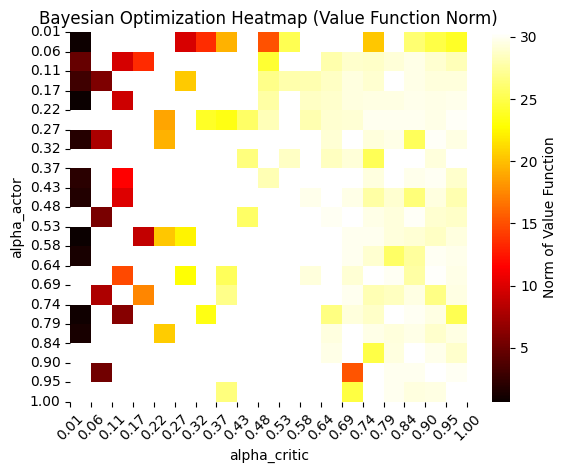

In [37]:
# 绘制 heatmap
import seaborn as sns
import pandas as pd

# 提取实验数据
trials_df = study.trials_dataframe()

# 生成 DataFrame 用于绘制 heatmap
df = pd.DataFrame({
    'alpha_actor': trials_df['params_alpha_actor'],
    'alpha_critic': trials_df['params_alpha_critic'],
    'value_norm': trials_df['value']
})

# 将 alpha_actor, alpha_critic 离散化到固定的表格
grid_size = 20
df['alpha_actor_bin'] = pd.cut(df['alpha_actor'], bins=np.linspace(0.01, 1.0, grid_size), labels=False)
df['alpha_critic_bin'] = pd.cut(df['alpha_critic'], bins=np.linspace(0.01, 1.0, grid_size), labels=False)

# 使用 pivot_table 创建二维表
heatmap_data = df.pivot_table(index='alpha_actor_bin', columns='alpha_critic_bin', values='value_norm', aggfunc='mean')

# 使用 seaborn 绘制 heatmap
sns.heatmap(heatmap_data, cmap='hot', annot=False, cbar_kws={'label': 'Norm of Value Function'})

# 设置轴标签和标题
plt.title('Bayesian Optimization Heatmap (Value Function Norm)')
plt.xlabel('alpha_critic')
plt.ylabel('alpha_actor')

# 生成 x 和 y 轴的 ticks
alpha_ticks = np.linspace(0.01, 1.0, grid_size)
plt.xticks(ticks=np.arange(len(alpha_ticks)), labels=[f'{x:.2f}' for x in alpha_ticks], rotation=45)
plt.yticks(ticks=np.arange(len(alpha_ticks)), labels=[f'{x:.2f}' for x in alpha_ticks], rotation=0)

plt.show()

# Step 3: Statistical tests

Now you have to compare the performance of the actor-critic algorithm tuned
with all the best hyper-parameters you found before, using statistical tests.

The functions below are provided to run Welch's T-test over learning curves.
They have been adapted from a github repository: https://github.com/flowersteam/rl_stats
You don't need to understand them in detail (though it is always a good idea to try to understand more code).

# 第三步：统计测试

现在，你需要对比使用前面找到的所有最佳超参数调优后的**演员-评论家算法**的性能，使用**统计测试**进行对比。

下面提供的函数用于对学习曲线运行**Welch’s T检验**。  
这些函数是从以下 GitHub 仓库改编的：https://github.com/flowersteam/rl_stats  
你不需要详细理解这些函数（尽管理解更多代码总是个好主意）。

In [38]:
from scipy.stats import ttest_ind
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [39]:
def compute_central_tendency_and_error(id_central, id_error, sample):

    try:
        id_error = int(id_error)
    except:
        pass

    if id_central == "mean":
        central = np.nanmean(sample, axis=1)
    elif id_central == "median":
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == "std":
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == "sem":
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
    else:
        raise NotImplementedError

    return central, low, high

In [40]:
def run_test(test_id, data1, data2, alpha=0.05):
    """
    Compute tests comparing data1 and data2 with confidence level alpha
    :param test_id: (str) refers to what test should be used
    :param data1: (np.ndarray) sample 1
    :param data2: (np.ndarray) sample 2
    :param alpha: (float) confidence level of the test
    :return: (bool) if True, the null hypothesis is rejected
    """
    data1 = data1.squeeze()
    data2 = data2.squeeze()
    n1 = data1.size
    n2 = data2.size

    # perform Welch t-test":
    _, p = ttest_ind(data1, data2, equal_var=False)
    return p < alpha

This last function was adapted for the lab.

最后这个函数是为该实验室改编的。

In [41]:
def perform_test(perf1, perf2, name1, name2, sample_size=20, downsampling_fact=5, confidence_level=0.01):

    perf1 = perf1.transpose()
    perf2 = perf2.transpose()
    nb_datapoints = perf1.shape[1]
    nb_steps = perf1.shape[0]

    legend = [name1, name2]

    # what do you want to plot ?
    id_central = 'mean' # "median"  # 
    id_error = 80  # (percentiles), also: 'std', 'sem'

    test_id = "Welch t-test"  # recommended
    
    sample1 = perf1[:, np.random.randint(0, nb_datapoints, sample_size)]
    sample2 = perf2[:, np.random.randint(0, nb_datapoints, sample_size)]

    steps = np.arange(0, nb_steps, downsampling_fact)
    sample1 = sample1[steps, :]
    sample2 = sample2[steps, :]

    # test
    sign_diff = np.zeros([len(steps)])
    for i in range(len(steps)):
        sign_diff[i] = run_test(
            test_id, sample1[i, :], sample2[i, :], alpha=confidence_level
        )

    central1, low1, high1 = compute_central_tendency_and_error(
        id_central, id_error, sample1
    )
    central2, low2, high2 = compute_central_tendency_and_error(
        id_central, id_error, sample2
    )

    # plot
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    lab1 = plt.xlabel("training steps")
    lab2 = plt.ylabel("performance")

    plt.plot(steps, central1, linewidth=10)
    plt.plot(steps, central2, linewidth=10)
    plt.fill_between(steps, low1, high1, alpha=0.3)
    plt.fill_between(steps, low2, high2, alpha=0.3)
    leg = ax.legend(legend, frameon=False)

    # plot significative difference as dots
    idx = np.argwhere(sign_diff == 1)
    y = max(np.nanmax(high1), np.nanmax(high2))
    plt.scatter(steps[idx], y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="o")

    # style
    for line in leg.get_lines():
        line.set_linewidth(10.0)
    ax.spines["top"].set_linewidth(5)
    ax.spines["right"].set_linewidth(5)
    ax.spines["bottom"].set_linewidth(5)
    ax.spines["left"].set_linewidth(5)

    plt.savefig(
        f"./{name1}_{name2}.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    )
    # plt.show()

## Exercise 3

As hyper-parameters, you will use:

- naive tuning, that is a pair (0.5, 0.5) for the actor and critic learning rates,
- the best hyper-parameters you found with the different tuning algorithms you used before.

### 1. For each set of hyper-parameters, collect a large dataset of learning curves.

We suggest using 150 training episodes.

### 2. Perform statistical comparisons

- Take two datasets of learning curves obtained with the hyper-parameters sets that you found with different tuning algorithms.
- Use the ``` perform_test(...)``` function to compare each possible pair of sets.

You should obtain an image for each pair you have tried.
In this image, black dots signal the time step where there is a statistically significant difference between two learning curves.

 ### 3. Conclude.

## 练习 3

作为超参数，你将使用：

- **简单调优**：即演员和评论家的学习率为 (0.5, 0.5) 的组合，
- 使用前面不同调优算法找到的**最佳超参数**。

### 1. 对每组超参数，收集大量学习曲线数据集。

我们建议使用150个训练回合。

### 2. 进行统计比较

- 选取使用不同调优算法找到的超参数组所得到的两组学习曲线数据集。
- 使用 `perform_test(...)` 函数比较每一对可能的超参数组。

你应该为每一对超参数组生成一张图像。在图像中，**黑点**表示在某个时间步上，两个学习曲线之间存在**统计显著差异**。

### 3. 总结分析

In [42]:
# To be completed...

# assert False, 'Not implemented yet'


In [43]:
# 1. For each set of hyper-parameters, collect a large dataset of learning curves.

# 收集 n_runs 次学习曲线的函数
def collect_learning_curves(mdp, alpha_actor, alpha_critic, n_runs=10, n_episodes=150):
    curves = []

    # 重复 n_runs 次来收集多个学习曲线
    for _ in range(n_runs):
        
        v, v_list, time_list = Actor_Critic(
            mdp=mdp,
            nb_episodes=n_episodes,
            timeout=50,
            alpha_actor=alpha_actor,
            alpha_critic=alpha_critic,
            render=False
        )

        # 记录学习曲线
        curves.append(v_list)

    return np.array(curves)   # 返回所有曲线数据



In [44]:
# naive tuning
naive_alpha_critic = 0.5
naive_alpha_actor = 0.5

naive_curves = collect_learning_curves(env, naive_alpha_actor, naive_alpha_critic)

In [45]:
# Bayesian optimization method tuning (optuna)
Bayes_alpha_critic = study.best_params["alpha_critic"]
Bayes_alpha_actor = study.best_params["alpha_actor"]

Bayes_curves = collect_learning_curves(env, Bayes_alpha_actor, Bayes_alpha_critic)

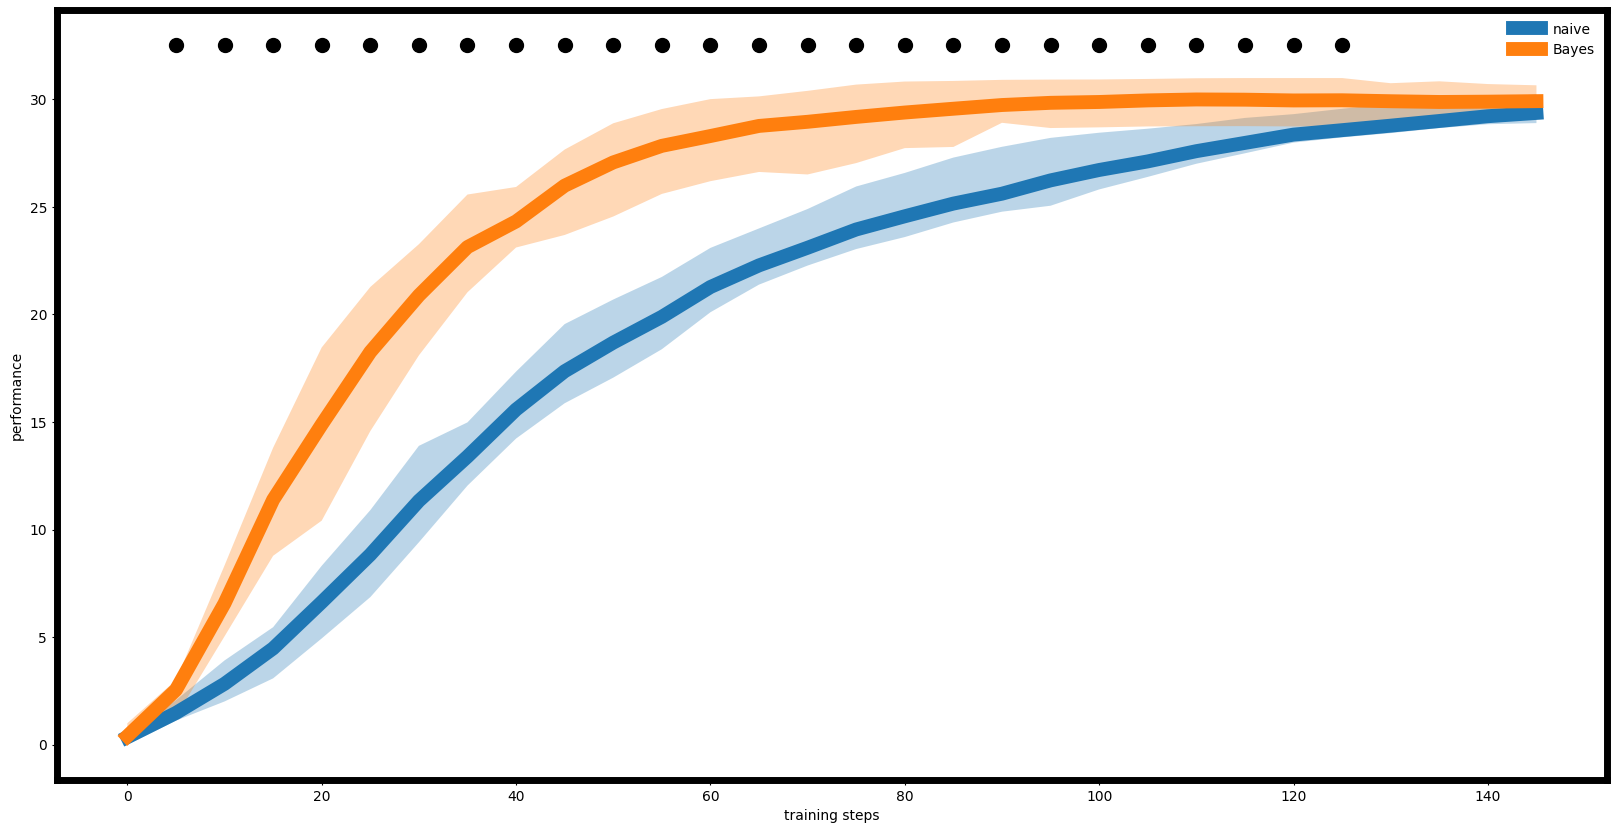

In [46]:
# 2. Perform statistical comparisons

# 比较 naive 和 Bayes 
perform_test(perf1=naive_curves, perf2=Bayes_curves, name1='naive', name2='Bayes')

# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of the choices you have made: the parameters you have set, the libraries you have used, etc.,
    + the heatmaps obtained using the hyper-parameters tuning algorithms that you have used,
    + the figures resulting from performing Welch's T-test using the best hyper-parameters from the above approaches,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can try using a Q-function as critic, using random search as hyper-parameters tuning algorithm,
using more challenging environments, etc.

# 实验报告

你的报告应包含以下内容：
- 你的源代码（通常是这个笔记本），不要忘记在笔记本的顶部写上你的名字，
- 一个单独的 PDF 文件，文件名中包含你的名字：
  + 详细描述你所做的选择：你设置的参数、使用的库等，
  + 使用超参数调优算法生成的热图，
  + 使用最佳超参数进行 Welch’s T 检验后得到的图像，
  + 你从这些实验中得出的结论。

除了报告中要求的内容，任何额外的研究都会获得加分。  
例如，你可以尝试使用 Q 函数作为评论家，使用随机搜索作为超参数调优算法，使用更具挑战性的环境等。